# Finite difference method: Poisson equation in 1D
Consider the one-dimensional Poisson equation 
$$
\left\{
\begin{aligned}
-u''(x) &= f(x) &\quad \text{in } \Omega = (0,1) \\
u(0) &= a \\
u(1) &= b
\end{aligned}
\right.
$$
Let $f(x)$ be a given function and $a, b$ be given numbers. The second derivative will be approximated by using central differential quotients. The system matrix should be stored in a sparse format.

As a test problem, use the given solution 
$$
u(x) = \frac{1}{4\pi^2} \sin(2\pi x) + x \; .
$$

Plot the exact and the numerical solution for $n = 8, 16, 32$ inner points. Plot the error $\max_i |u(x_i) - u_h(x_i)|$ w.r.t. the mesh size $h$ on a log-log-scale.

## Solution

Let's first compute the first and second derivative of $u$: 
$$
\begin{align*}
u'(x) &= \frac{1}{2\pi} \cos(2\pi x) + 1 \\
u''(x) &= - \sin(2\pi x)
\end{align*}
$$
Now we know that the function $f$ is given by 
$$
f(x) = \sin(2\pi x) \; .
$$
By evaluating $u$ at the boundary points $x = 0$ and $x = 1$, we get the boundary values of the problem:
$$
\begin{align*}
u(0) &= \frac{1}{4\pi^2} \sin(0) + 0 = 0 \\
u(1) &= \frac{1}{4\pi^2} \sin(2\pi) + 1 = 1 
\end{align*}
$$

In [1]:
f(x) = sin.(2pi * x)

f (generic function with 1 method)

We divide the interval $\Omega = (0, 1)$ into a equidistant mesh with $N$ inner points and mesh size $h = \frac{1}{N+1}$:
$$
0 = x_0 < x_1 < x_2 < \ldots < x_N < x_{N+1} = 1
$$

By using central differential quotients, we get 
$$
\frac{-u(x_{i-1}) + 2u(x_i) - u(x_{i+1})}{h^2} = f(x_i) \; , \quad i = 2, \ldots, N-1 \; .
$$

At the points $x_1$ and $x_N$ we plug in the boundary conditions:
$$
\begin{align*}
\frac{2 u(x_1) - u(x_2)}{h^2} &= f(x_1) + h^2 a \\
\frac{-u(x_{N-1}) + 2 u(x_N)}{h^2} &= f(x_N) + h^2 b
\end{align*}
$$
This gives us a system of $N$ linear equations with $N$ unknowns.

Now, let's write a Julia function, which assembles and solves this linear equation system:

In [2]:
using SparseArrays
function solve_poisson_1d(N, a, b, f)
    x = range(0, stop=1, length=N+2)
    h = 1/(N+1)
    
    x_inner = x[2:end-1]
    f_inner = f(x_inner)
    boundary_vec = similar(x_inner)
    boundary_vec[1] = a
    boundary_vec[end] = b
    rhs = h^2 * f_inner + boundary_vec
    
    main_diag = 2*ones(N)
    upper_diag = -1*ones(N-1)
    lower_diag = -1*ones(N-1)
    system_matrix = spdiagm(-1 => lower_diag, 0 => main_diag, 1 => upper_diag)
    u_inner = system_matrix \ rhs
    u = u_inner
    pushfirst!(u,a)
    push!(u, b)
    return u
end

solve_poisson_1d (generic function with 1 method)

In [3]:
function exact_solution(N)
    u(x) = 1/(4*pi^2) * sin.(2*pi*x) + x
    x = collect(range(0, stop=1, length=N+2))
    return u(x)
end

exact_solution (generic function with 1 method)

Let's calculate the numerical and exact solution for $N = 8, 16, 32$.

In [4]:
N_vec = [8, 16, 32]
h_vec = [1/(n+1) for n in N_vec]
a = 0
b = 1
numerical_solutions = []
exact_solutions = []
for n in N_vec
    push!(numerical_solutions, solve_poisson_1d(n, a, b, f))
    push!(exact_solutions, exact_solution(n))
end

Now let's write a Julia function to plot the exact and numerical solution.

In [5]:
using PyPlot
function plot_exact_numerical(u_exact, u_numerical)
    n = length(u_numerical) - 2
    x = range(0, stop=1, length=n+2)
    plot(x, u_exact)
    plot(x, u_numerical, "o")
    title(string("Numerical and exact solution for ", n, " inner points"))
    xlabel("x")
    legend(("exact solution", "numerical solution"))
end

plot_exact_numerical (generic function with 1 method)

Let's plot the exact and numerical solution for 8 inner points:

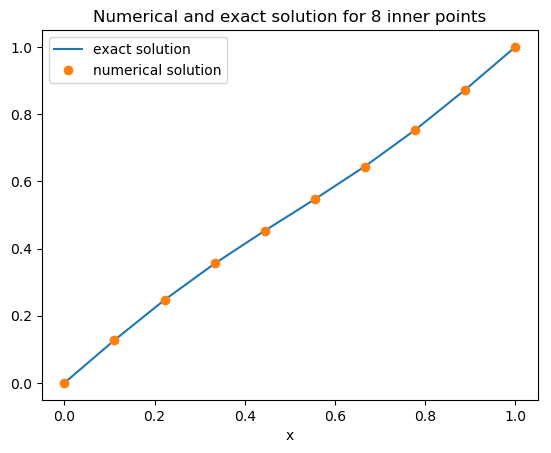

PyObject <matplotlib.legend.Legend object at 0x7f2a0c3e5c50>

In [6]:
plot_exact_numerical(exact_solutions[1], numerical_solutions[1])

Let's do the same for 16 and 32 inner points:

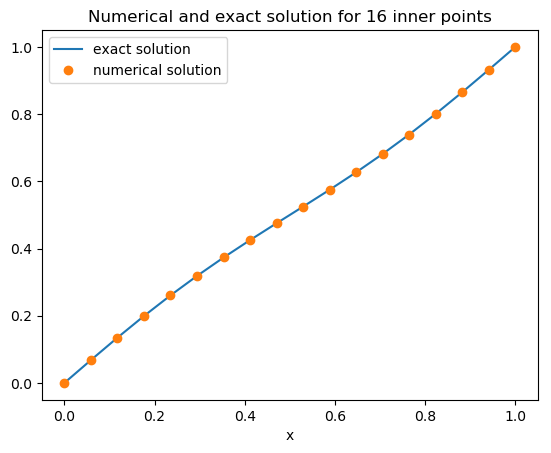

PyObject <matplotlib.legend.Legend object at 0x7f29f8447f98>

In [7]:
plot_exact_numerical(exact_solutions[2], numerical_solutions[2])
#savefig("numsol16.pdf")

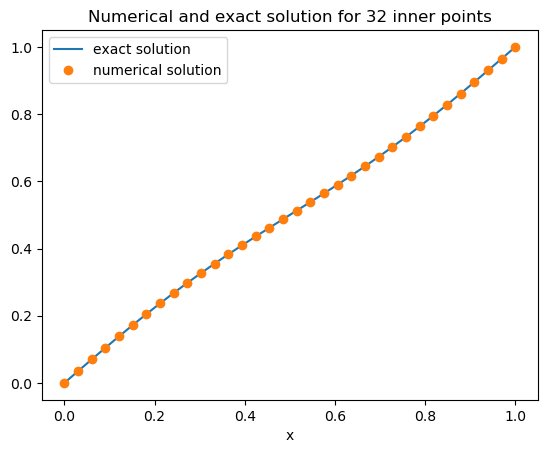

PyObject <matplotlib.legend.Legend object at 0x7f29f83c2358>

In [8]:
plot_exact_numerical(exact_solutions[3], numerical_solutions[3])

Let's calculate the error between the exact solutions and the numerical solutions, and plot the error on a log-log-scala.

In [9]:
errors = [maximum(abs, num - ex) for (num, ex) in zip(numerical_solutions, exact_solutions)]

3-element Array{Float64,1}:
 0.0010383530131146124
 0.0002890923471681739
 7.657487707157795e-5 

Finally, let's plot the error on a log-log scala.

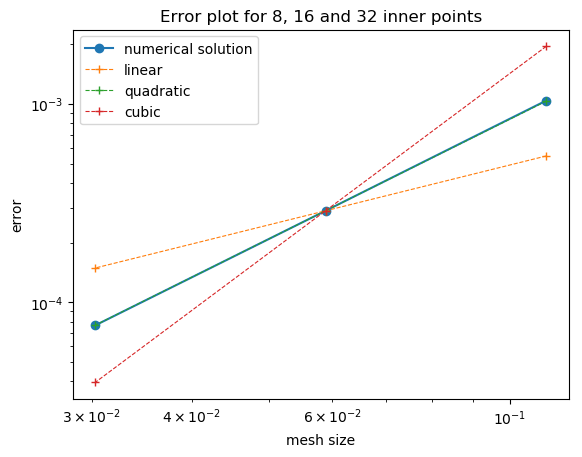

PyObject Text(24.000000000000007, 0.5, 'error')

In [10]:
loglog(h_vec, errors, "-o")
c1 = errors[2]/h_vec[2]
loglog(h_vec, c1*h_vec, "--+", linewidth=0.8)
c2 = errors[2]/(h_vec[2]^2)
loglog(h_vec, c2*h_vec.^2, "--+", linewidth=0.8)
c3 = errors[2]/(h_vec[2]^3)
loglog(h_vec, c3*h_vec.^3, "--+", linewidth=0.8)
legend(["numerical solution", "linear", "quadratic", "cubic"])
title("Error plot for 8, 16 and 32 inner points")
xlabel("mesh size")
ylabel("error")